<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson03_CNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lesson 3. Simple CNN excerise
## 1. Improve lesson 2's code
## 2. Save the usually-used code
## 3. Try to implement your simple CNN using the MNIST dataset
## 4. Compare the results between CNN and DNN
## 5. Maybe it is slow. Try to improve the speed of the SGD


In [92]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features_and_labels(features, labels, size_of_class, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()


def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[0]
    split_index = int(m * split_rate)

    indices = np.array(range(m))
    np.random.shuffle(indices)

    train_indices, test_indices = np.array(indices[0:split_index]), np.array(indices[split_index:])
    train_features, train_labels = feature_matrix[train_indices, :], label_matrix[train_indices, :]
    test_features, test_labels = feature_matrix[test_indices, :], label_matrix[test_indices, :]

    return train_features, train_labels, test_features, test_labels


def draw_neuron_boundary(neuron, features, labels, markers, colors, grid_step=0.5, size_of_class= 2):
    min_x, max_x = np.min(features[:, 0]), np.max(features[:, 0])
    min_y, max_y = np.min(features[:, 1]), np.max(features[:, 1])

    xx, yy = np.meshgrid(np.arange(min_x - 1, max_x + 1, grid_step), np.arange(min_y - 1, max_y + 1, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    predict = neuron.predict(grid_points)
    argmax_index = np.argmax(predict, axis=1)

    positive_index = grid_points[np.where(argmax_index == 0), :]
    negative_index = grid_points[np.where(argmax_index == 1), :]

    plt.figure(figsize=(4, 4))
    for i in range(size_of_class):
        class_index = grid_points[np.where(argmax_index == i), :]
        plt.scatter(class_index[0, :, 0], class_index[0, :, 1], c=colors[i], alpha=0.1)

    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

#Exercise 1. Do a warm up exercise with double moon dataset
## 1. Design a complex multiple classes classfication problem
## 2. Try to use lesson 2's code
## 3. Improve lesson 2's code


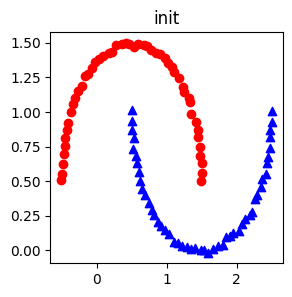

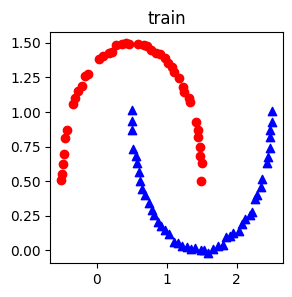

In [93]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 1
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
#plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')

In [94]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        m = dL_by_dZ.shape[0]
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        #dZ/dW = X.T (n+1, m) .dot dL/dZ = (m, out)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) / m #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        self.Y_hat = self.process_function(Z)
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

In [95]:
class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [96]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


(90, 2)
(90, 2)


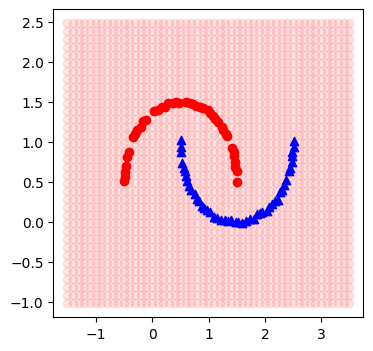

Epoch 1
-------------------------------
loss : 0.7548092474920794


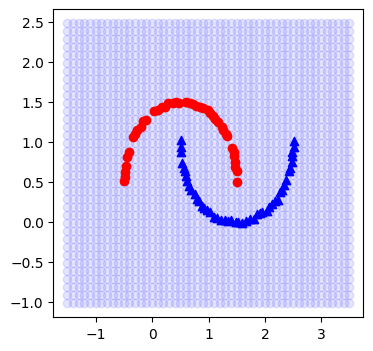

loss : 0.3810935360616009


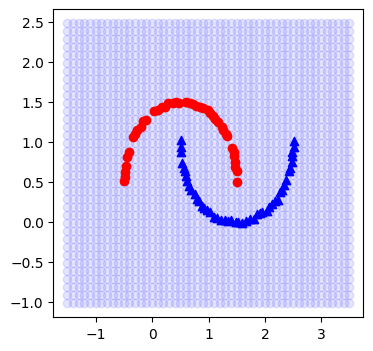

Epoch 21
-------------------------------
loss : 0.07739962309403663


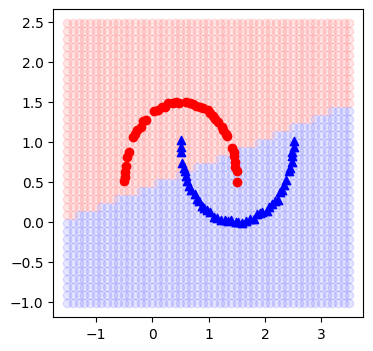

loss : 0.0879491648100205


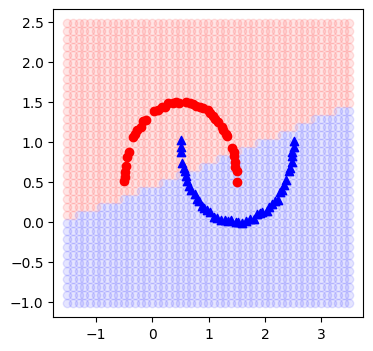

Epoch 41
-------------------------------
loss : 0.04154282808181192


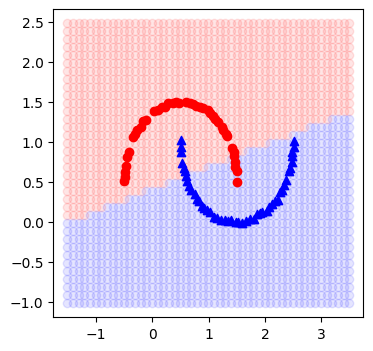

loss : 0.04500154797630141


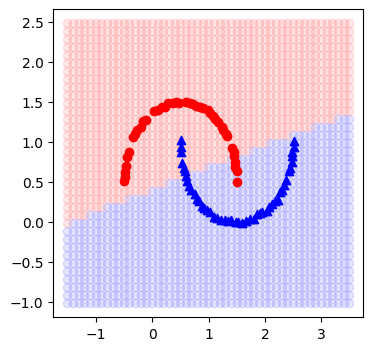

Epoch 61
-------------------------------
loss : 0.028827816544414925


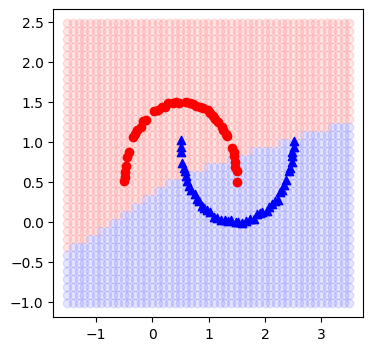

loss : 0.03079981311586307


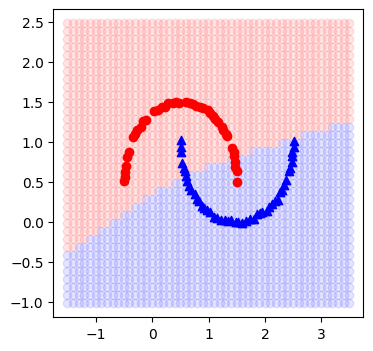

In [97]:
demo_neuron = SimpleDNN(2, 2)
loss = Cross_Entropy_Loss()

print(train_features.shape)
print(train_labels.shape)

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 20 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 20 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

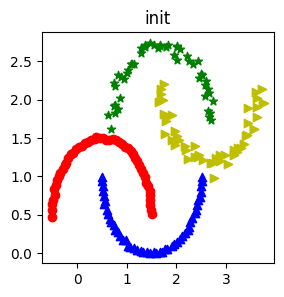

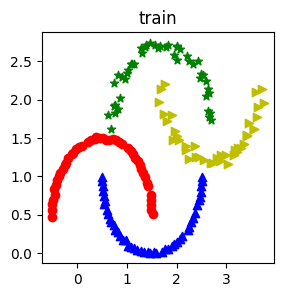

In [98]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 2
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [99]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


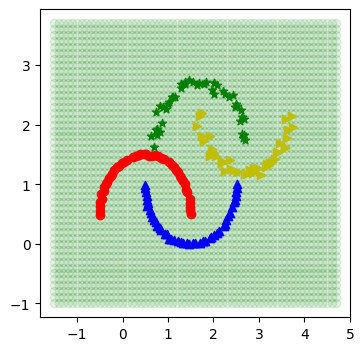

Epoch 1
-------------------------------
loss : 0.6681249524591545


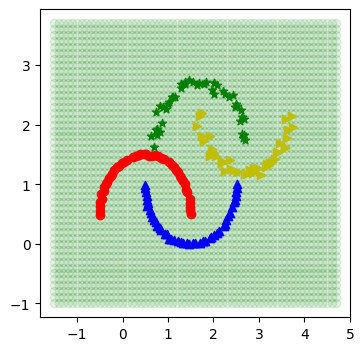

loss : 1.7698463617175608


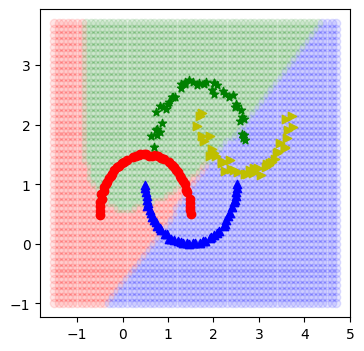

Epoch 11
-------------------------------
loss : 2.0351145796704126


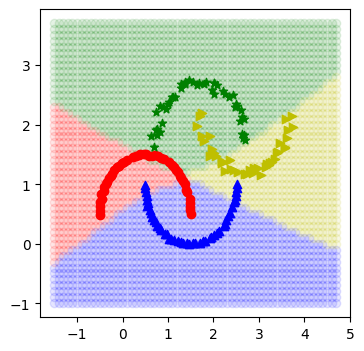

loss : 3.3479831778006366


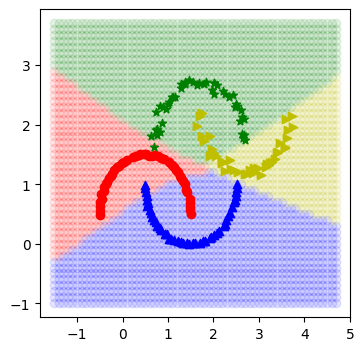

Epoch 21
-------------------------------
loss : 3.2508461230366237


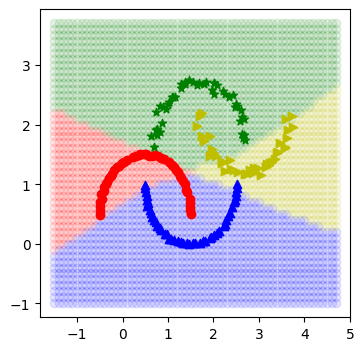

loss : 3.644305190723247


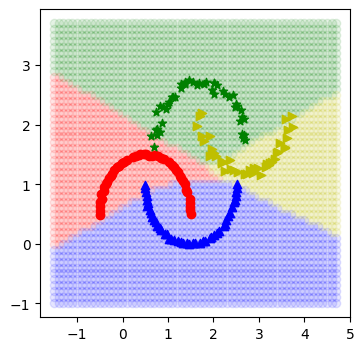

Epoch 31
-------------------------------
loss : 2.0001066116202026


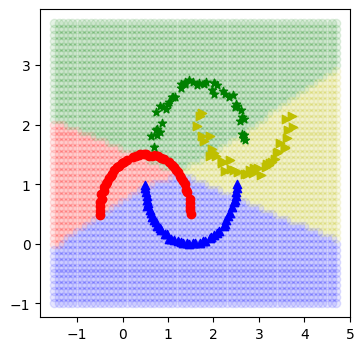

loss : 3.0670451134135512


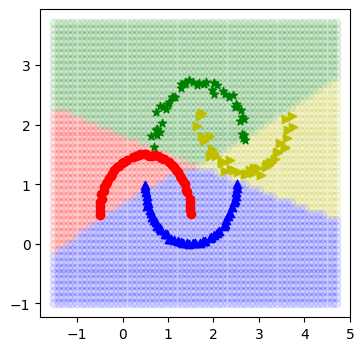

Epoch 41
-------------------------------
loss : 1.224534477395404


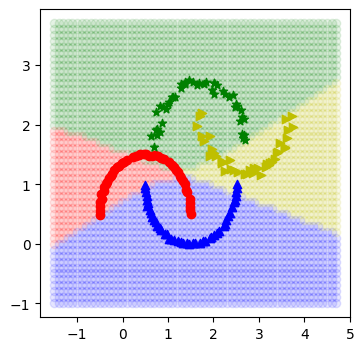

loss : 3.2065182031969997


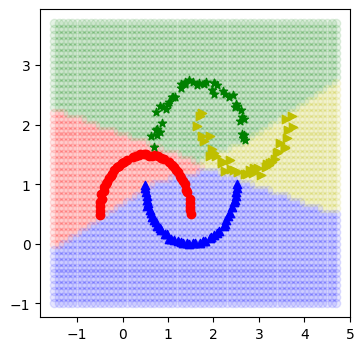

Epoch 51
-------------------------------
loss : 0.823190239921667


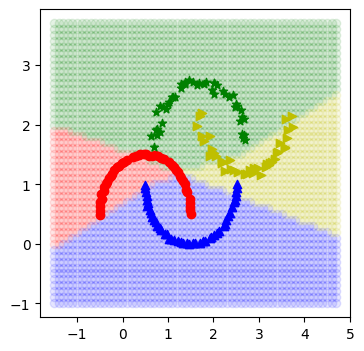

loss : 2.9438782753158885


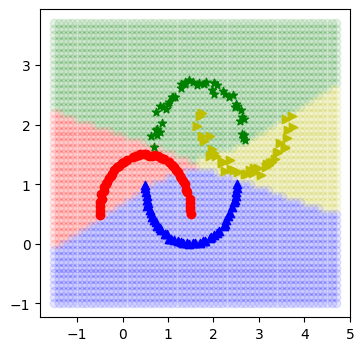

Epoch 61
-------------------------------
loss : 0.2765278197449962


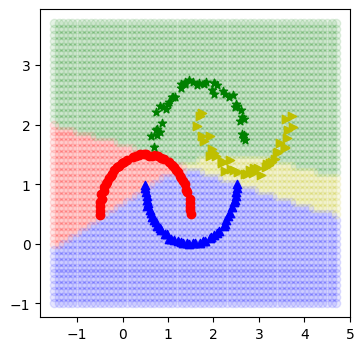

loss : 2.5986382845936045


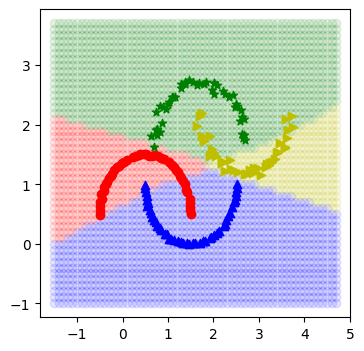

Epoch 71
-------------------------------
loss : 0.6960810323719552


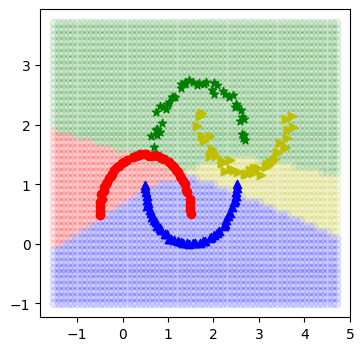

loss : 2.5615544157793786


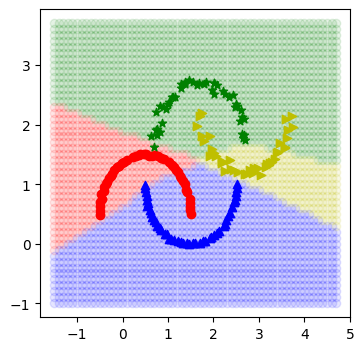

In [100]:
demo_neuron = SimpleDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 10 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 2. Warm up exercise 2 with double moon dataset
## 1. Try to use a complex DNN to fix a multiple classes classfication problem


In [101]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

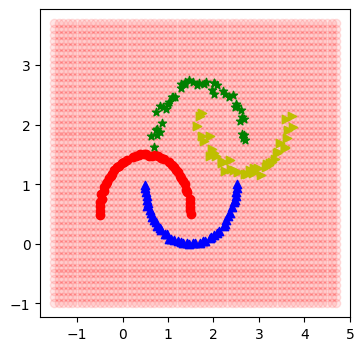

Epoch 1
-------------------------------
loss : 1.0044340944480246


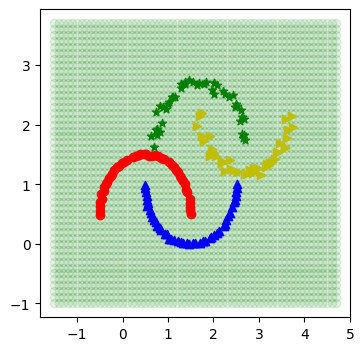

loss : 1.6173437041927328


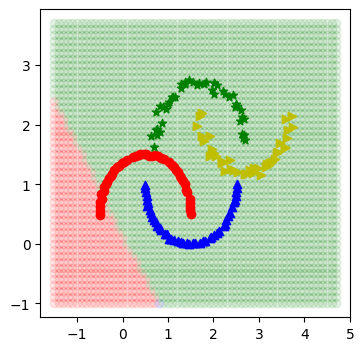

Epoch 51
-------------------------------
loss : 0.07664275542021151


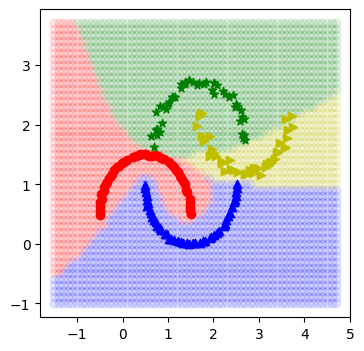

loss : 2.4364266513197346


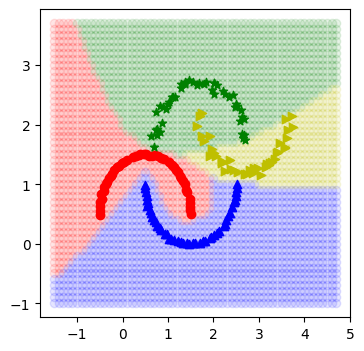

Epoch 101
-------------------------------
loss : 0.44406735015261245


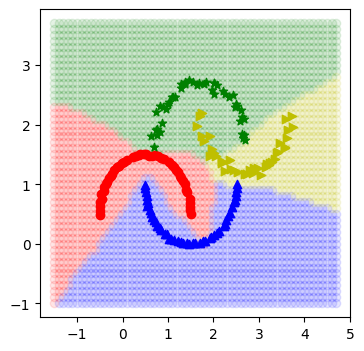

loss : 0.3120240286232851


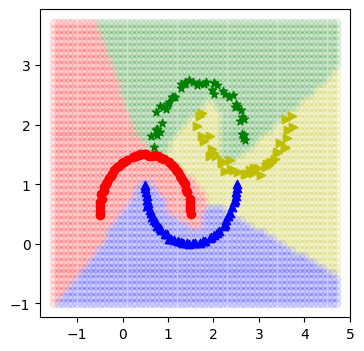

Epoch 151
-------------------------------
loss : 0.0022512741225439114


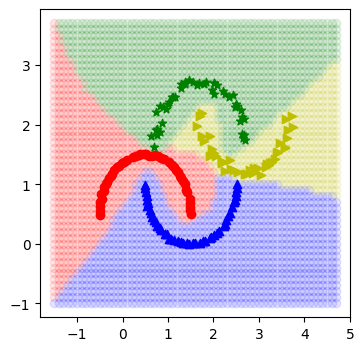

loss : 0.0012587752550943221


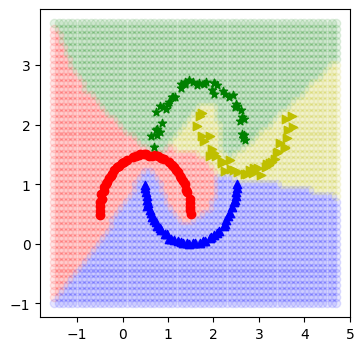

In [102]:
demo_neuron = ComplexDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 200
m = train_labels.shape[0]
for t in range(epochs):
    if t % 50 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 50 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 3: Warm up exercise 3
## 1. A more complicated multiple class classification problem


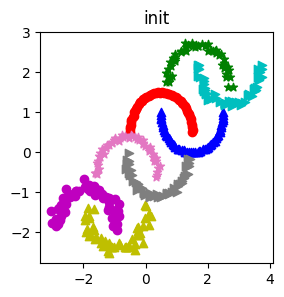

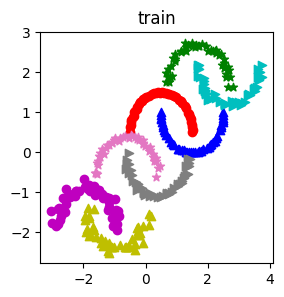

In [103]:
from sklearn.datasets import make_moons, make_circles
import matplotlib.colors as mcolors

time_of_iter = 4
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter
#plot_colortable(mcolors.TABLEAU_COLORS, ncols=2, sort_colors=False)
markers = ['o', '^', '*', '>', 'o', '^', '*', '>', '<' ]
colors = ['r', 'b', 'g', 'c', 'm', 'y', mcolors.TABLEAU_COLORS['tab:pink'], mcolors.TABLEAU_COLORS['tab:gray'], mcolors.TABLEAU_COLORS['tab:olive']]
noises = [0.01, 0.06, 0.1, 0.04]
random_indexs = [0.5, 1.7, -1.9, -0.6]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [104]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

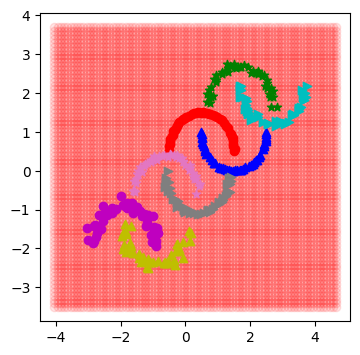

Epoch 1
-------------------------------
loss : 1.668076435962585


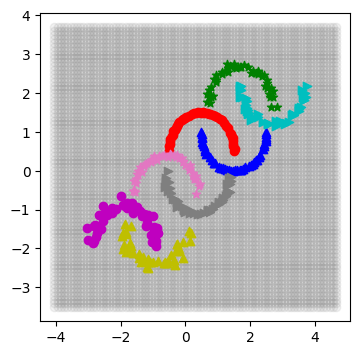

loss : 1.6802643991171546


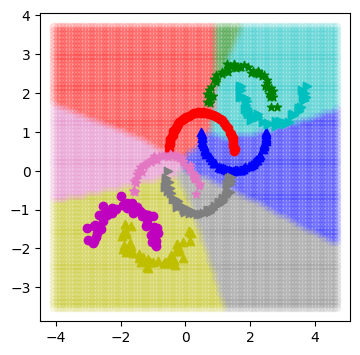

Epoch 101
-------------------------------
loss : 0.0006162591688248225


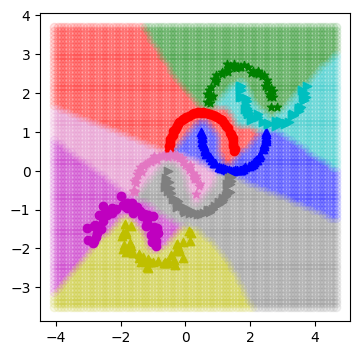

loss : 0.0002368679810828961


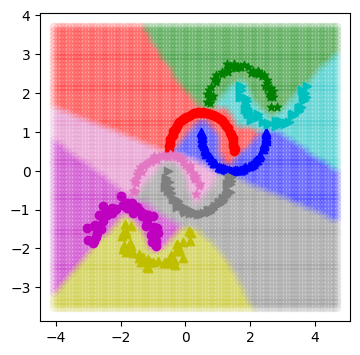

Epoch 201
-------------------------------
loss : 0.00016946287772431036


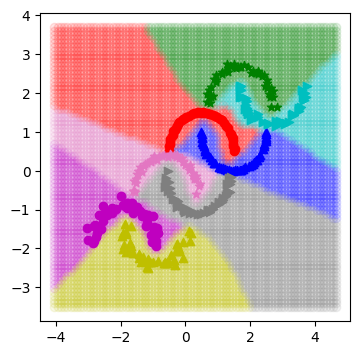

loss : 5.927802938204159e-05


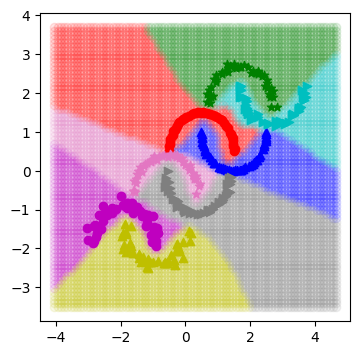

Epoch 301
-------------------------------
loss : 9.37494680507977e-05


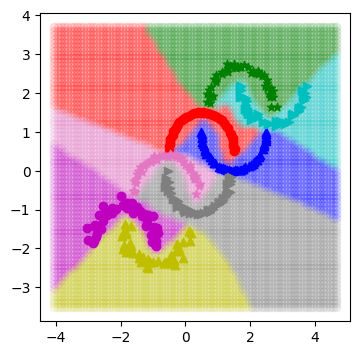

loss : 3.5298028133456116e-05


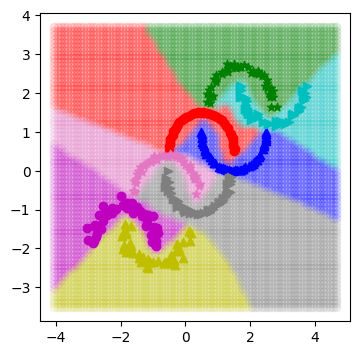

In [105]:
demo_neuron = ComplexDNN(2, 8)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 400
m = train_labels.shape[0]
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 100 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 4: A classical experiment -- MNIST
1. Use your implement of DNN to get a baseline
2. Try to implement your simple CNN model and get the correct bp
3. Use Pytorh CNN model to compare with your own CNN in the effect and speed


In [120]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [121]:
tt = transforms.Compose([transforms.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
test_data = MNIST(root='./data', train=False, transform=tt)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


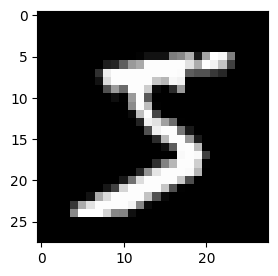

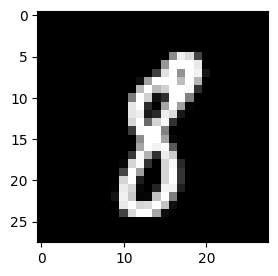

In [122]:
np_train_features = train_data.data.numpy()
np_train_labels = train_data.targets.numpy()

np_test_features = test_data.data.numpy()
np_test_labels = test_data.targets.numpy()

print(train_data.data.shape)
print(train_data.targets.shape)
print(test_data.data.shape)
print(test_data.targets.shape)

#print(train_data.data[0])
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[0], cmap='gray')
plt.show()
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[300], cmap='gray')
plt.show()

In [123]:
import numpy as np
train_features = np.resize(np_train_features, (np_train_features.shape[0], 28 * 28))
train_labels = np.zeros((np_train_labels.shape[0], 10))
for i in range(10):
    train_labels[np.where(np_train_labels == i), i] = 1

test_features = np.resize(np_test_features, (np_test_features.shape[0], 28 * 28))
test_labels = np.zeros((np_test_labels.shape[0], 10))
for i in range(10):
    test_labels[np.where(np_test_labels == i), i] = 1

In [124]:
print(train_features.shape)
print(train_labels.shape)
print(train_labels[0])

print(test_features.shape)
print(test_labels.shape)
print(test_labels[0])

(60000, 784)
(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(10000, 784)
(10000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [144]:
class MnistDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 150),
            Sigmoid_Active_Function(),
            Linear(150, 150),
            Sigmoid_Active_Function(),
            Linear(150, 150),
            Sigmoid_Active_Function(),
            Linear(150, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

In [145]:
def shuffle_dataset(n, batch_size):
    idices= np.array(range(n))
    np.random.shuffle(idices)
    batch_sample_size = int((n - n % batch_size) / batch_size)
    m = int(batch_size * batch_sample_size)
    a = idices[0:m].reshape((batch_size, batch_sample_size))
    b = idices[m:].reshape((1, n % batch_size))
    return a

shuffle_dataset(100, 4)

array([[54,  0, 23, 19, 45, 10,  1, 37, 70, 78, 22, 57, 38, 83, 21, 51,
        89, 55, 48, 76, 71, 84, 18, 63, 64],
       [94,  6,  2, 52, 77, 12, 74, 33, 28, 17, 80, 62, 73, 86, 85, 26,
        81, 96, 20, 31, 42, 58, 98, 44, 87],
       [32, 88, 65, 39, 69, 34, 16, 47, 15, 27, 60, 61, 82, 53, 59, 79,
        95, 93, 56,  4, 90, 13, 67, 50, 46],
       [ 9, 91, 92, 29, 35, 24, 72, 36, 11, 30,  8,  5, 40, 99, 68, 14,
        97, 41, 66, 49, 43, 25, 75,  7,  3]])

In [146]:
def get_precision(predict, y):
    a = np.argmax(predict, axis=1)
    b = np.argmax(y, axis=1)

    print(np.sum(a == b) / y.shape[0])

In [147]:
demo_neuron = MnistDNN(28*28, 10)
loss = Cross_Entropy_Loss()

epochs = 200
m = train_labels.shape[0]
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_size = 60
    batch_matrix = shuffle_dataset(m, batch_size)

    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X = train_features[batch_index, :]
        Y = train_labels[batch_index, :]

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.5)

    if t % 5 == 0:
        predicts = demo_neuron.predict(train_features)
        print('train:')
        get_precision(predicts, train_labels)

        predicts = demo_neuron.predict(test_features)
        print('test:')
        get_precision(predicts, test_labels)

    print('t:', t+1, ' loss :', l)

Epoch 1
-------------------------------


<ipython-input-94-9db4f4321738>:2: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))


train:
0.6059
test:
0.611
t: 1  loss : 1200.8747467234289
t: 2  loss : 759.6894911848938
t: 3  loss : 631.4783203676603
t: 4  loss : 504.01997477481524
t: 5  loss : 491.9111093039488
train:
0.84675
test:
0.8525
t: 6  loss : 524.4163353116259
t: 7  loss : 462.7915847884592
t: 8  loss : 457.62903096503806
t: 9  loss : 441.6427033312964
t: 10  loss : 444.7439864115829
Epoch 11
-------------------------------
train:
0.8772166666666666
test:
0.8783
t: 11  loss : 399.1650512010371
t: 12  loss : 374.94584573526583
t: 13  loss : 438.6834092141055
t: 14  loss : 408.1410355843067
t: 15  loss : 372.17272767112735
train:
0.8934333333333333
test:
0.8915
t: 16  loss : 332.034605897107
t: 17  loss : 301.5020719210369
t: 18  loss : 353.04212500262776
t: 19  loss : 396.7783379059128
t: 20  loss : 337.19278581948595
Epoch 21
-------------------------------
train:
0.9035333333333333
test:
0.8993
t: 21  loss : 349.34765884131673
t: 22  loss : 299.2069470713578
t: 23  loss : 361.46545904431287
t: 24  loss 

In [148]:
#Save the model

model = demo_neuron.model
parameter_list = []
for i in range(len(model.operator_list)):
    if i % 2 == 0:
        print(model.operator_list[i].W.shape)
        np.savetxt('DNN_Mnist_model_%d.txt' % i, model.operator_list[i].W, delimiter=',')

(785, 150)
(151, 150)
(151, 150)
(151, 10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')